# Blood Cell Classification
Subtypes : Eosinophil, Lymphocyte, Monocyte and Neutrophil

## Importing Modules

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import os
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
import pandas as pd
import cv2

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Organize

In [2]:
def pplus(*things):
    sentence = ""
    for i in things:
        if not isinstance(i, str):
            i  =  str(i)
        sentence += " " +i
    print('------------------------------------')
    print(sentence)
    print('------------------------------------')

In [3]:
DIR = "../input/dataset2-master/dataset2-master/images/"
TEST = "../input/dataset2-master/dataset2-master/images/TEST/"
TRAIN = "../input/dataset2-master/dataset2-master/images/TRAIN/"

In [4]:
batch_size = 96
test_size = 48
lr = 0.0002

## Inspecting

In [5]:
pplus("Top dir:", os.listdir("../input"))
pplus("dataset2 dir:", os.listdir(DIR))
pplus("TEST_SIMPLE:", os.listdir(DIR+"TEST_SIMPLE"))
pplus('samples in one TS dir:', len(os.listdir(DIR+"TEST_SIMPLE/MONOCYTE")))
pplus('samples in another TS dir:', len(os.listdir(DIR+"TEST_SIMPLE/EOSINOPHIL")))
print('Looks like Class imbalance, Plot a histogram to get proper estimate')
pplus(len(os.listdir(TEST+"MONOCYTE")))
pplus(len(os.listdir(TEST+"EOSINOPHIL")))
print('Looks like augmented set doesnot have any imbalance')


------------------------------------
 Top dir: ['dataset2-master', 'dataset-master']
------------------------------------
------------------------------------
 dataset2 dir: ['TEST_SIMPLE', 'TEST', 'TRAIN']
------------------------------------
------------------------------------
 TEST_SIMPLE: ['MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE', 'NEUTROPHIL']
------------------------------------
------------------------------------
 samples in one TS dir: 4
------------------------------------
------------------------------------
 samples in another TS dir: 13
------------------------------------
Looks like Class imbalance, Plot a histogram to get proper estimate
------------------------------------
 620
------------------------------------
------------------------------------
 623
------------------------------------
Looks like augmented set doesnot have any imbalance


In [6]:
mappings = dict(zip(['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE','LYMPHOCYTE'],list(range(0,4))))
print(mappings)

{'NEUTROPHIL': 0, 'EOSINOPHIL': 1, 'MONOCYTE': 2, 'LYMPHOCYTE': 3}


In [7]:
labels = pd.read_csv('../input/dataset2-master/dataset2-master/labels.csv')
pplus(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 3 columns):
Unnamed: 0    0 non-null float64
Image         411 non-null int64
Category      367 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 9.7+ KB
------------------------------------
 None
------------------------------------


In [8]:
pplus(labels.head())
pplus(labels.tail())

------------------------------------
    Unnamed: 0  Image    Category
0         NaN      0  NEUTROPHIL
1         NaN      1  NEUTROPHIL
2         NaN      2  NEUTROPHIL
3         NaN      3  NEUTROPHIL
4         NaN      4  NEUTROPHIL
------------------------------------
------------------------------------
      Unnamed: 0  Image    Category
406         NaN    406         NaN
407         NaN    407  NEUTROPHIL
408         NaN    408  NEUTROPHIL
409         NaN    409  NEUTROPHIL
410         NaN    410  EOSINOPHIL
------------------------------------


## Plotting a Sample of each

In [9]:
plt.figure(figsize=(16,16))

def plot_image(location, subplot):
    title = location.split('/')[0]
    location = TRAIN+location
    plt.subplot(subplot)
    plt.title(title)
    plt.axis('off')
    plt.imshow(cv2.imread(location))
    return


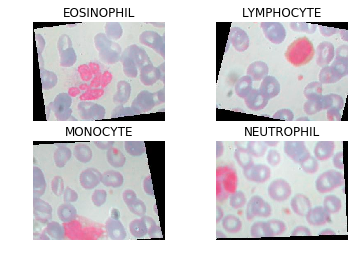

In [10]:
loc = []
loc.append('EOSINOPHIL/_0_207.jpeg')
loc.append('LYMPHOCYTE/_0_204.jpeg')
loc.append('MONOCYTE/_0_180.jpeg')
loc.append('NEUTROPHIL/_0_292.jpeg')

subplot = 221
for i in loc:
    plot_image(i, subplot)
    subplot += 1

In [11]:
from tqdm import tqdm
def get_data(folder):
    im = []
    labels = []
    for subtype in os.listdir(folder):
        if not subtype.startswith('.'):
            label = mappings[subtype]
        for img_name in tqdm(os.listdir(folder+subtype)):
            im.append(cv2.resize(cv2.imread(folder+subtype+'/'+img_name), (64,64)))
            labels.append(label)
    return np.asarray(im), np.asarray(labels)


In [12]:
train_im, train_labels = get_data(TRAIN)
test_im, test_labels = get_data(TEST)

100%|██████████| 624/624 [00:01<00:00, 433.55it/s]


## Create Custom Dataset Class

In [13]:
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]
        

In [14]:

tfms = transforms.Compose([transforms.ToTensor()])
train = BloodDataset(train_im, train_labels, transform=tfms)


mean = tuple((train_im.mean(axis=(0,1,2))/255).round(4))
std = tuple((train_im.std(axis=(0,1,2))/255).round(4))

tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean, std)])

train = BloodDataset(train_im, train_labels, transform=tfms)

pplus('Mean Values:',mean)
pplus('Std Dev',std)


------------------------------------
 Mean Values: (0.6606, 0.6414, 0.6787)
------------------------------------
------------------------------------
 Std Dev (0.2602, 0.2627, 0.2635)
------------------------------------


In [15]:
tfms = transforms.Compose([transforms.ToTensor()])
test = BloodDataset(test_im, test_labels, transform=tfms)

mean = tuple((test_im.std(axis=(0,1,2))/255).round(4))
std = tuple((test_im.std(axis=(0,1,2))/255).round(4))

tfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean, std)])
test = BloodDataset(test_im, test_labels, transform=tfms)

pplus('Mean Values:', mean)
pplus('Std Dev', std)

------------------------------------
 Mean Values: (0.2596, 0.2613, 0.2626)
------------------------------------
------------------------------------
 Std Dev (0.2596, 0.2613, 0.2626)
------------------------------------


In [16]:
# Only available in pytorch 0.4.1
# valid, training = torch.utils.data.random_split(train, len(train_labels)//10, len(train_labels)-len(train_labels)//10 )

In [17]:
train.__getitem__(3)[0]


(0 ,.,.) = 
 -2.5388 -2.5388 -2.5388  ...  -2.5388 -2.5388 -2.5388
 -2.5388 -2.5388 -2.5388  ...  -2.5388 -2.5388 -2.5388
 -2.5388 -2.5388 -2.5388  ...  -2.5388 -2.5388 -2.5388
           ...             ⋱             ...          
  0.4453  0.7015  0.1590  ...  -2.5388 -2.5388 -2.5388
  0.4755  0.6262  0.0987  ...  -2.5388 -2.5388 -2.5388
  0.5508  0.5207  0.0384  ...  -2.5388 -2.5388 -2.5388

(1 ,.,.) = 
 -2.4416 -2.4416 -2.4416  ...  -2.4416 -2.4416 -2.4416
 -2.4416 -2.4416 -2.4416  ...  -2.4416 -2.4416 -2.4416
 -2.4416 -2.4416 -2.4416  ...  -2.4416 -2.4416 -2.4416
           ...             ⋱             ...          
  0.5888  0.7978  0.1708  ...  -2.4416 -2.4416 -2.4416
  0.6933  0.6784  0.1410  ...  -2.4416 -2.4416 -2.4416
  0.7978  0.5440  0.1260  ...  -2.4416 -2.4416 -2.4416

(2 ,.,.) = 
 -2.5757 -2.5757 -2.5757  ...  -2.5757 -2.5757 -2.5757
 -2.5757 -2.5757 -2.5757  ...  -2.5757 -2.5757 -2.5757
 -2.5757 -2.5757 -2.5757  ...  -2.5757 -2.5757 -2.5757
           ...            

In [18]:
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=test_size, shuffle=False)

## Perfect! All looks good, now let's define our network
- Let's call it depth seperable wide resnet.

In [19]:


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer0 = self.conv(3,32)
        self.block1 = Block(32)
        self.block2 = Block(64)
        self.block3 = Block(128)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, 4)

    def conv(self, in_, out_): 
        return nn.Sequential(
            nn.Conv2d(in_, out_, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_))
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x
# ----------------------------------------------------------------------------------------#
class Block(nn.Module):
    def __init__(self, in_):
        super().__init__()
        self.layer1 = self.conv_ds(in_, in_*2)
        self.layer2 = self.conv_ds(in_*2, in_*2)
        self.layer2_1 = self.conv_bn(in_*2, in_*2)
        
        self.layer1_1x1 = self.one_by_one(in_, in_*2)

    def one_by_one(self, in_, out_):
        return nn.Sequential(
            nn.Conv2d(in_, out_, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_)
        )
    def conv_bn(self, in_, out_):
        return nn.Sequential(
            nn.Conv2d(in_, out_, 3, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_))
    
    def conv_ds(self, in_, out_): 
        mid = round(in_ * 3/2)
        return nn.Sequential(
            nn.Conv2d(in_, mid, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(mid),
            nn.Conv2d(mid, mid, 3, 1, 1, groups=mid, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(mid),
            nn.Conv2d(mid, out_, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_))
    def forward(self, x):
        x = self.layer1(x) + self.layer1_1x1(x)
        x = self.layer2(x) + x
        x = self.layer2_1(x)
        return x

In [20]:
print(Network())
if not torch.cuda.is_available(): pplus('Turn ON your GPU')
net = Network()
net = net.cuda()

Network(
  (layer0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  )
  (block1): Block(
    (layer1): Sequential(
      (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
      (4): ReLU(inplace)
      (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
      (6): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): ReLU(inplace)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (3): Conv2d(96, 96, kernel_si

## Create a Training Regime

In [21]:
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.85, weight_decay=1e-4)
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()

In [22]:
def test(epoch):
    net.eval()
    test_loss = 0
    counter = 0
    accuracy = 0

    for batch_idx , (data,targets) in enumerate(testloader):

        data, targets = Variable(data).cuda(), Variable(targets).cuda()

        outputs = net(data)
        loss = criterion(outputs, targets)

        test_loss += loss.data.cpu().numpy().round(5)
        counter += 1

        _, predicted = torch.max(outputs.data,1)
        accuracy += (predicted == targets.data).sum()
        
        if batch_idx%(batch_size//10) == 0:
            pplus('Test Epoch:', epoch, batch_idx*len(data),'/',len(testloader.dataset),
                  '|\n Test Loss:',loss.data.cpu().numpy().round(5),
                  '|\n Accuracy:', (accuracy*100/(targets.data.size(0)*(batch_idx+1)))
                 )
    return test_loss/counter

In [23]:
def train(epoch):
    net.train()
    train_loss = 0
    counter = 0
    accuracy = 0
    for batch_idx, (data, targets) in enumerate(trainloader):
        data, targets = Variable(data).cuda(), Variable(targets).cuda()
        optimizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs, targets)
        train_loss += loss.data.cpu().numpy().round(5)
        counter += 1
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data,1)
        accuracy += (predicted == targets.data).sum()
        
        if batch_idx%(batch_size//10) == 0:
            pplus('Train Epoch:', epoch, batch_idx*len(data),'/',len(trainloader.dataset),
                  '|\n Train Loss:',loss.data.cpu().numpy().round(5),
                  '|\n Accuracy:', (accuracy*100/(targets.data.size(0)*(batch_idx+1)))
                 )
    return train_loss/counter

In [24]:
train_stack = []
test_stack = []

## Plotting function

In [25]:
def plot_arrays(np_arr, np_arr2):
    plt.plot(np_arr)
    plt.plot(np_arr2)
    plt.xlabel('Epochs --->')
    plt.ylabel('Loss --->')
    plt.title('Training Curve')
    plt.show()
    


## Train it for 200 epochs

------------------------------------
 Train Epoch: 0 0 / 9957 |
 Train Loss: [1.38977] |
 Accuracy: 26.041666666666668
------------------------------------
------------------------------------
 Train Epoch: 0 864 / 9957 |
 Train Loss: [1.33234] |
 Accuracy: 32.916666666666664
------------------------------------
------------------------------------
 Train Epoch: 0 1728 / 9957 |
 Train Loss: [1.16877] |
 Accuracy: 39.30921052631579
------------------------------------
------------------------------------
 Train Epoch: 0 2592 / 9957 |
 Train Loss: [1.01151] |
 Accuracy: 45.200892857142854
------------------------------------
------------------------------------
 Train Epoch: 0 3456 / 9957 |
 Train Loss: [0.92656] |
 Accuracy: 49.66216216216216
------------------------------------
------------------------------------
 Train Epoch: 0 4320 / 9957 |
 Train Loss: [0.76571] |
 Accuracy: 53.80434782608695
------------------------------------
------------------------------------
 Train Epoch: 0 

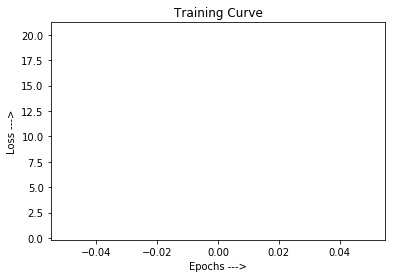

------------------------------------
 Train Epoch: 1 0 / 9957 |
 Train Loss: [0.37927] |
 Accuracy: 91.66666666666667
------------------------------------
------------------------------------
 Train Epoch: 1 864 / 9957 |
 Train Loss: [0.29825] |
 Accuracy: 93.125
------------------------------------
------------------------------------
 Train Epoch: 1 1728 / 9957 |
 Train Loss: [0.23427] |
 Accuracy: 93.53070175438596
------------------------------------


KeyboardInterrupt: 

In [26]:
for i in range(200):
    train_stack.append(train(i))
    test_stack.append(test(i))
    plot_arrays(train_stack, test_stack)

## Save loss logs as csv file

In [ ]:
diction = {'train_loss': train_stack, 'test_loss': test_stack}
df = pd.DataFrame(diction)
df.to_csv('log.csv')